In [76]:
import joblib
joblib.cpu_count()

80

Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [75]:
# !pip install --upgrade pip

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns



%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
---------

In [66]:
import sklearn
sklearn.__dir__()
sklearn.__version__

'1.0.2'

In [67]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    ocsvm_nu=0.037,
    ocsvm_gamma= 0.001,
)
# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [68]:
P = VALID_ROBUST_OCSVM
# P = VALID_NORMALIZER_OCSVM

In [69]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [70]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

In [71]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22631, gyro_count: 23835
44) accel_count: 24473, gyro_count: 23749


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


45) accel_count: 23974, gyro_count: 23229
46) accel_count: 23614, gyro_count: 23827


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 22828, gyro_count: 23904
49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 24049, gyro_count: 26943
2) accel_count: 24468, gyro_count: 27667


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 24611, gyro_count: 27000
4) accel_count: 24972, gyro_count: 26798


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 23573, gyro_count: 23372
6) accel_count: 23800, gyro_count: 23890


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 23347, gyro_count: 24145
8) accel_count: 22947, gyro_count: 22660


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 26156, gyro_count: 25815
21) accel_count: 23566, gyro_count: 24408


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 23844, gyro_count: 24589
26) accel_count: 23179, gyro_count: 23925


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 25109, gyro_count: 25820
28) accel_count: 23133, gyro_count: 24028


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 23180, gyro_count: 24314
35) accel_count: 23299, gyro_count: 23854


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 25497, gyro_count: 25059
37) accel_count: 25994, gyro_count: 25232


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


38) accel_count: 21164, gyro_count: 21182
39) accel_count: 24214, gyro_count: 23585


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


40) accel_count: 23944, gyro_count: 23170
41) accel_count: 23193, gyro_count: 24111


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 26505, gyro_count: 25697
43) accel_count: 22690, gyro_count: 23981


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 23002, gyro_count: 23829
45) accel_count: 23978, gyro_count: 23350


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 21128, gyro_count: 21848
48) accel_count: 27996, gyro_count: 27205


/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 23061, gyro_count: 24129


In [72]:
len(dfList_exp1)

29

In [10]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

# Butterworth+EMA

<AxesSubplot:>

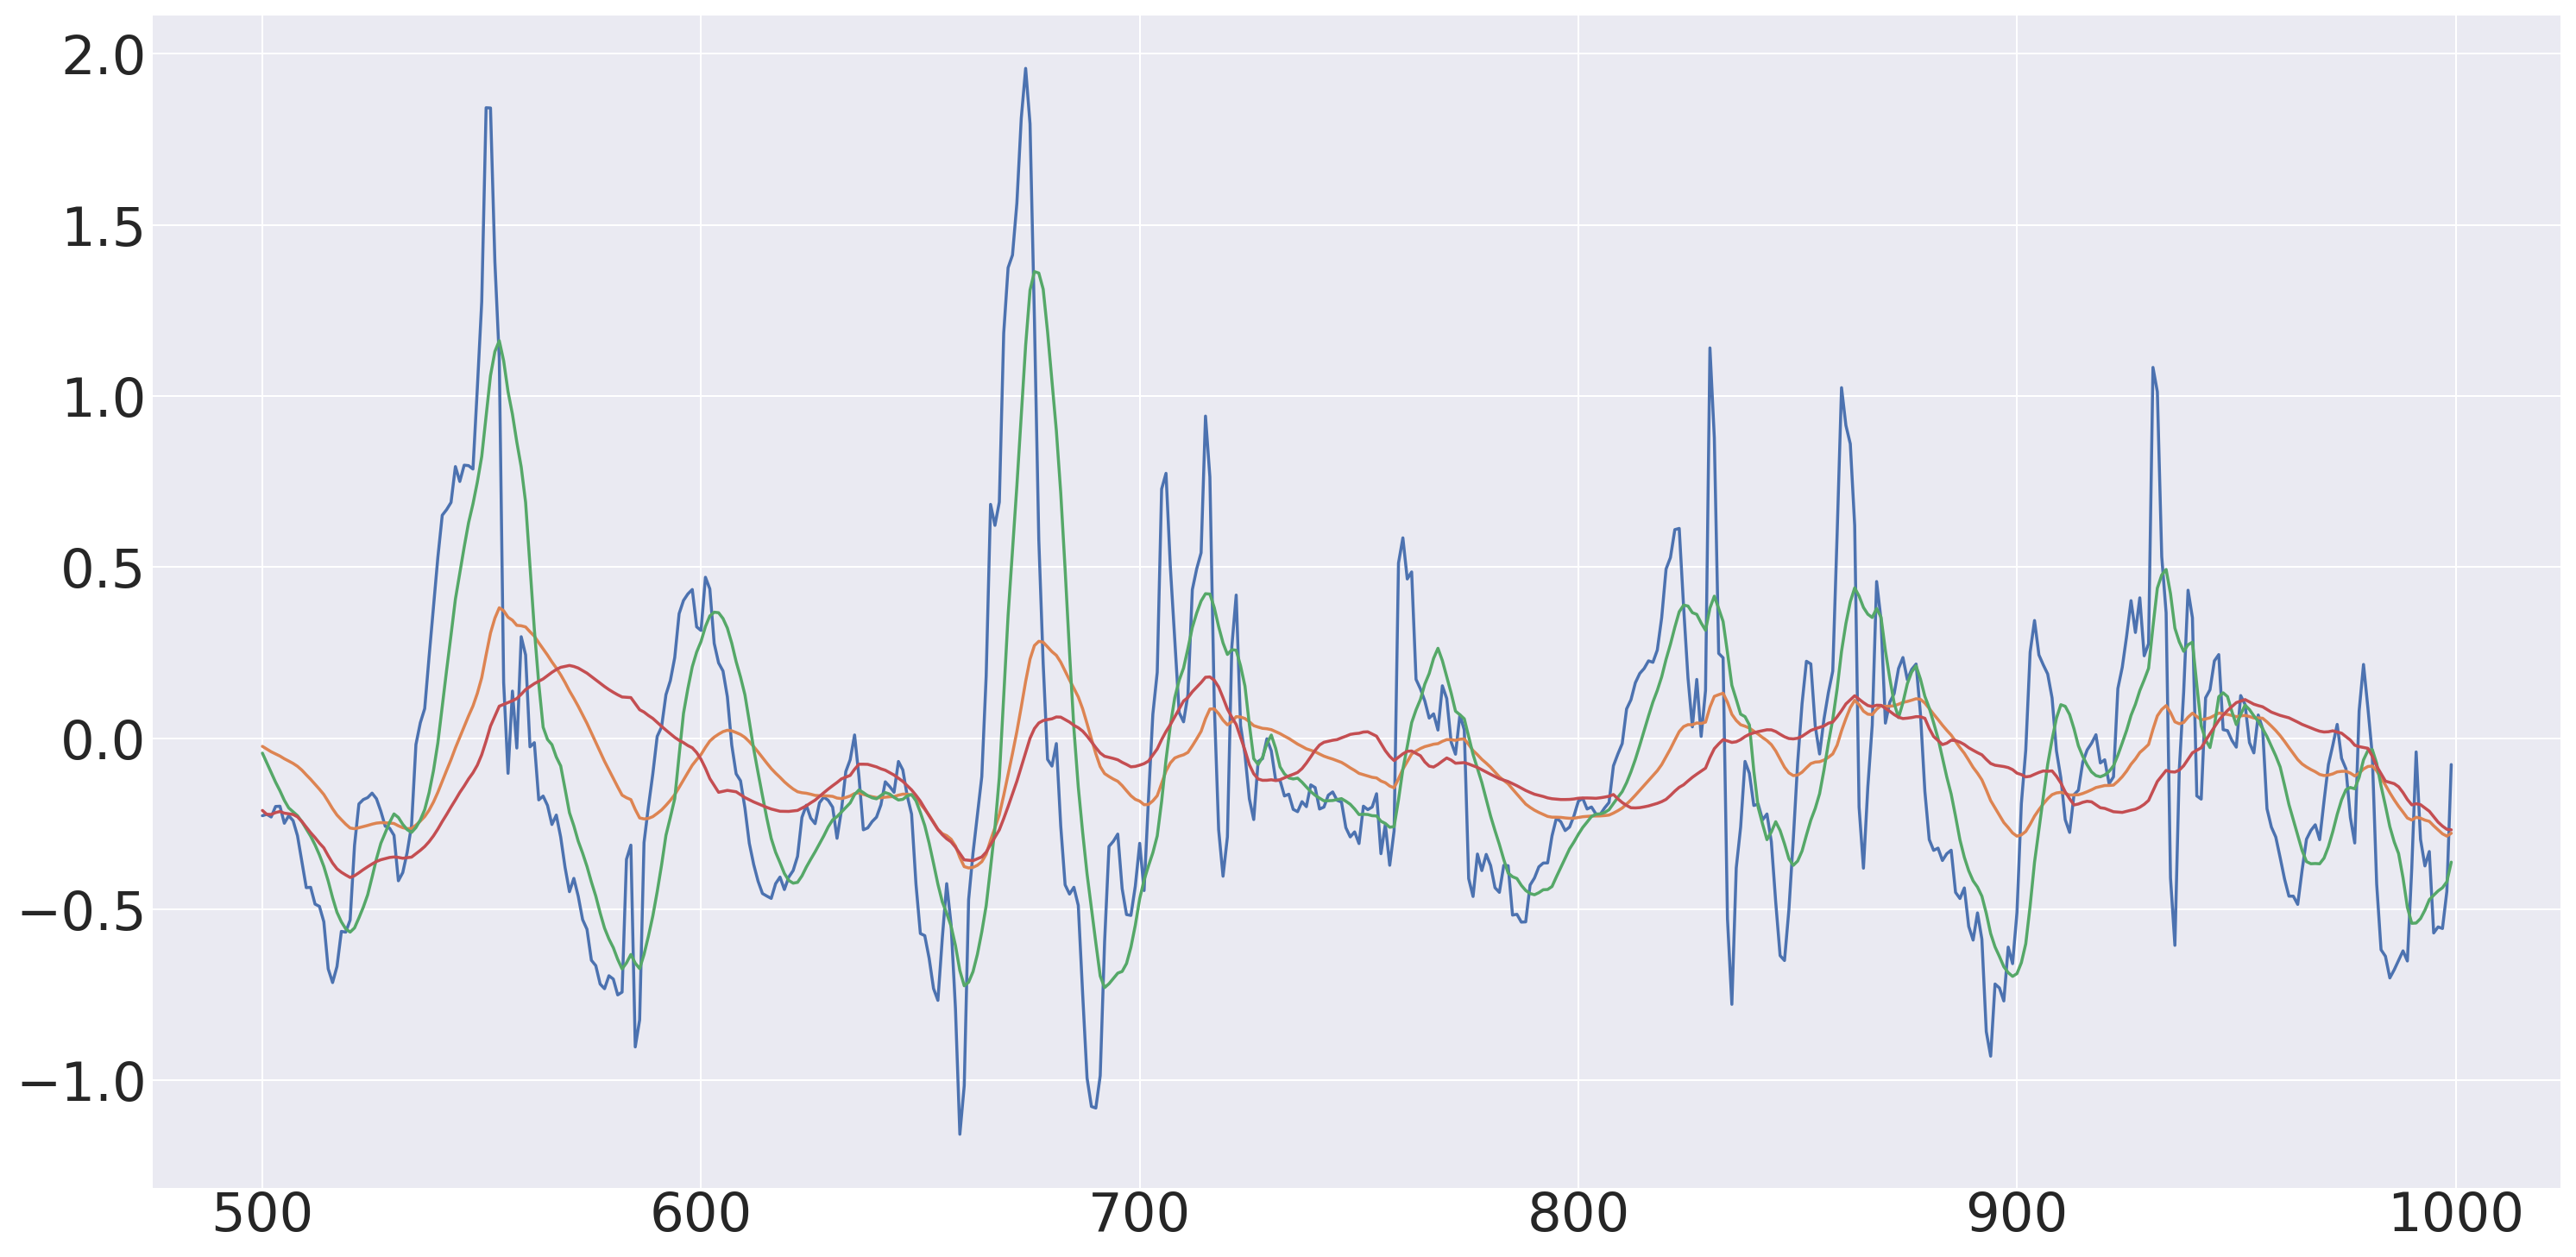

In [87]:
P.span=49
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [14]:
i=0
raw_dfList_exp2[i]['x_a'][500:1000].rolling(window=10, min_periods=0, closed="both").mean()

500   -0.211201
501   -0.222568
502   -0.222900
503   -0.217521
504   -0.214294
         ...   
995   -0.480356
996   -0.468062
997   -0.455767
998   -0.438447
999   -0.388494
Name: x_a, Length: 500, dtype: float64

In [15]:
raw_dfList_exp2[i]['x_a'][500:1000]

500   -0.211201
501   -0.233935
502   -0.223566
503   -0.201385
504   -0.201385
         ...   
995   -0.557577
996   -0.557577
997   -0.557577
998   -0.437594
999   -0.096048
Name: x_a, Length: 500, dtype: float32

In [16]:
# i=0
# dfList_exp1[i][['x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['z_g']].plot(figsize=(30, 6))

# dfList_exp2[i][['x_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['y_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['z_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['x_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['y_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['z_g']].plot(figsize=(30, 6))
# exp1 idx 10 has corrupted data frist 50 sec
# exp2 idx 12 has some artifacts first 12.5 sec
# exp1 idx 17 has some artifacts first 75 sec
# exp2 idx 23 has some artifacts last 6.5 sec

In [17]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
# train_set = randomized_data_idx
print(f"train_set: {train_set}\ntest_set: {test_set}")
# train_set = test_set
# test_set = train_set
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226


/tmp/ipykernel_6218/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_6218/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


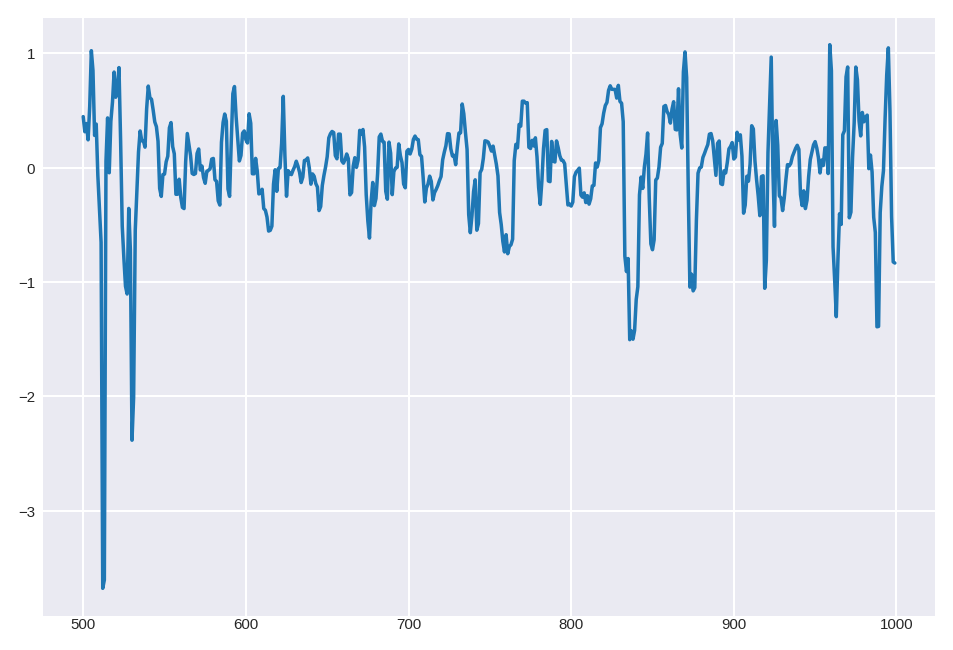

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
getRawDataChunks - user_key: 7, exp_num: 1, scaler: None
getRawDataChunks - user_key: 24, exp_num: 1, scaler: None
getRawDataChunks - user_key: 8, exp_num: 1, scaler: None
getRawDataChunks - user_key: 11, exp_num: 1, scaler: None
getRawDataChunks - user_key: 13, exp_num: 1, scaler: None
getRawDataChunks - user_key: 19, exp_num: 1, scaler: None
getRawDataChunks - user_key: 28, exp_num: 1, scaler: None
getRawDataChunks - user_key: 21, exp_num: 1, scaler: None
getRawDataChunks - user_key: 26, exp_num: 1, scaler: None
getRawDataChunks - user_key: 3, exp_num: 1, scaler: None
getRawDataChunks - user_key: 20, exp_num: 1, scaler: None
getRawDataChunks - user_key: 22, exp_num: 1, scaler: None
getRawDataChunks - user_key: 6, exp_num: 1, scaler: None
getRawDataChunks - 

In [89]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
# EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()

# dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
# dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.ocsvm_step_width, 
                                                                                                  scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                  EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                               X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [19]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]


In [20]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [21]:
# OCSVM_test_train_WACA_features_dic[0].shape

In [22]:
# plot_EER_distro(Mean_EER_df, 500)

In [23]:
train_set
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [79]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 27,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
train_set[:-19]
P.Butter_per_win_argdict=None
EMA_per_win_span=None
SMA_per_win_winsize=None

In [94]:
overlap=.5
window_size=2000
step_width = int(window_size * (1-overlap))
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler=P.scaler, 
                                                                                                                    num_sample_points_per_exp=P.num_sample_points_per_exp, EMA_per_win_span=EMA_per_win_span,
                                                                                                                    SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                               X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict)



len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
getRawDataChunks - user_key: 7, exp_num: 1, scaler: None
getRawDataChunks - user_key: 24, exp_num: 1, scaler: None
getRawDataChunks - user_key: 8, exp_num: 1, scaler: None
getRawDataChunks - user_key: 11, exp_num: 1, scaler: None
getRawDataChunks - user_key: 13, exp_num: 1, scaler: None
getRawDataChunks - user_key: 19, exp_num: 1, scaler: None
getRawDataChunks - user_key: 28, exp_num: 1, scaler: None
getRawDataChunks - user_key: 21, exp_num: 1, scaler: None
getRawDataChunks - user_key: 26, exp_num: 1, scaler: None
getRawDataChunks - user_key: 3, exp_num: 1, scaler: None
getRawDataChunks - user_key: 20, exp_num: 1, scaler: None
getRawDataChunks - user_key: 22, exp_num: 1, scaler: None
getRawDataChunks - user_key: 6, exp_num: 1, scaler: None
getRawDataChunks - user_key: 25, exp_num: 1, scaler: None
getRawDataChunks - user_key: 16, exp_num: 1, scaler: None
getRawDataChunks - user_key: 1, exp_num: 1, scaler: None
getRawDataChunk

In [95]:
# %run ./utility-functions.ipynb
n_neighbors=1
verbose=0
columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
Mean_EER_df = pd.DataFrame(columns = columns)
# return X_exp_train_dic
columns = ['owner', "adv_user_id", "EER"]
EER_distro_df = pd.DataFrame(columns = columns)

EER_distro_df = make_EER_distro_df(X_exp_train_dic, n_neighbors=1, algorithm='brute', verbose=0)

y_col = "EER"
mean_col = EER_distro_df[y_col].mean()
Mean_EER = mean_col
Mean_EER_df_columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
new_row = pd.DataFrame([[window_size, step_width, True, Mean_EER]], columns=Mean_EER_df_columns)
Mean_EER_df = pd.concat([Mean_EER_df, new_row])

In [27]:
# %run ./utility-functions.ipynb


In [28]:
dfList_dict={"dfList_exp1": dfList_exp1,
            "dfList_exp2": dfList_exp2,
            "dfList_exp1_user_47": dfList_exp1_user_47,
            "dfList_exp2_user_47": dfList_exp2_user_47,}
EER_distro_df

,owner,adv_user_id,EER
0,7,24,0.05
0,7,8,0.05
0,7,11,0.05
0,7,13,0.0
0,7,19,0.05
...,...,...,...
0,29,16,0.090909
0,29,1,0.090909
0,29,17,0.090909
0,29,27,0.090909


Overall mean: 0.1616


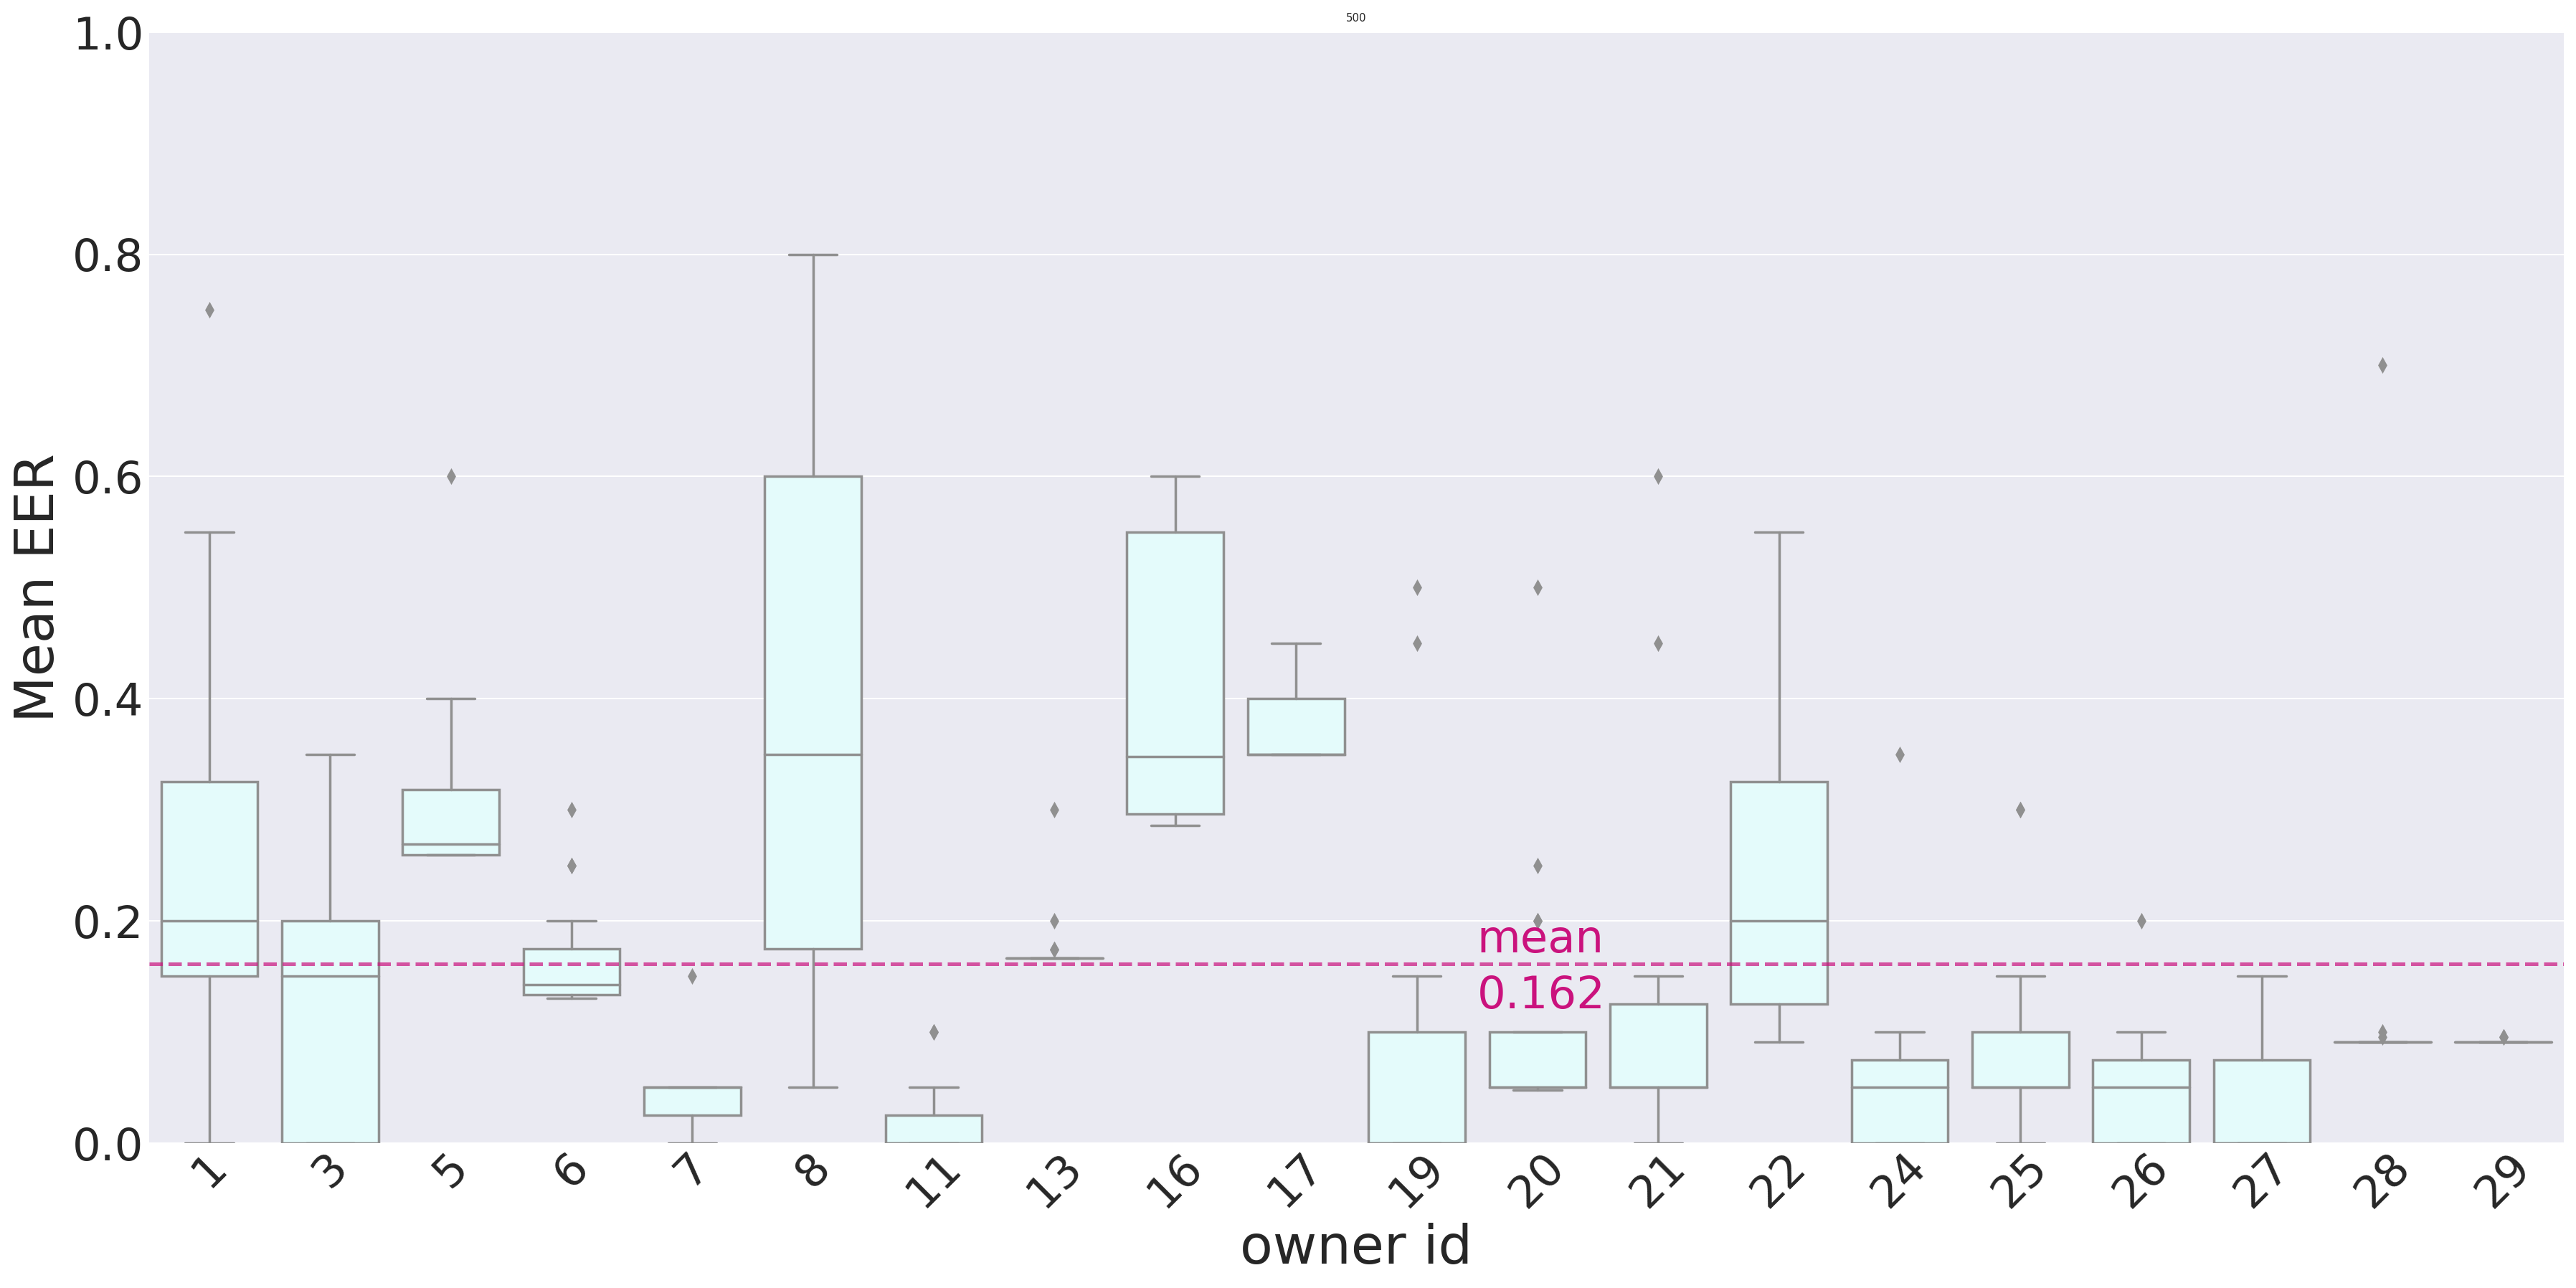

In [96]:
utils_plot_acc_eer_dist_thesis(EER_distro_df, "EER", 500, save_file_name=None, boxplot_color="lightcyan")


Overall mean: 0.1616


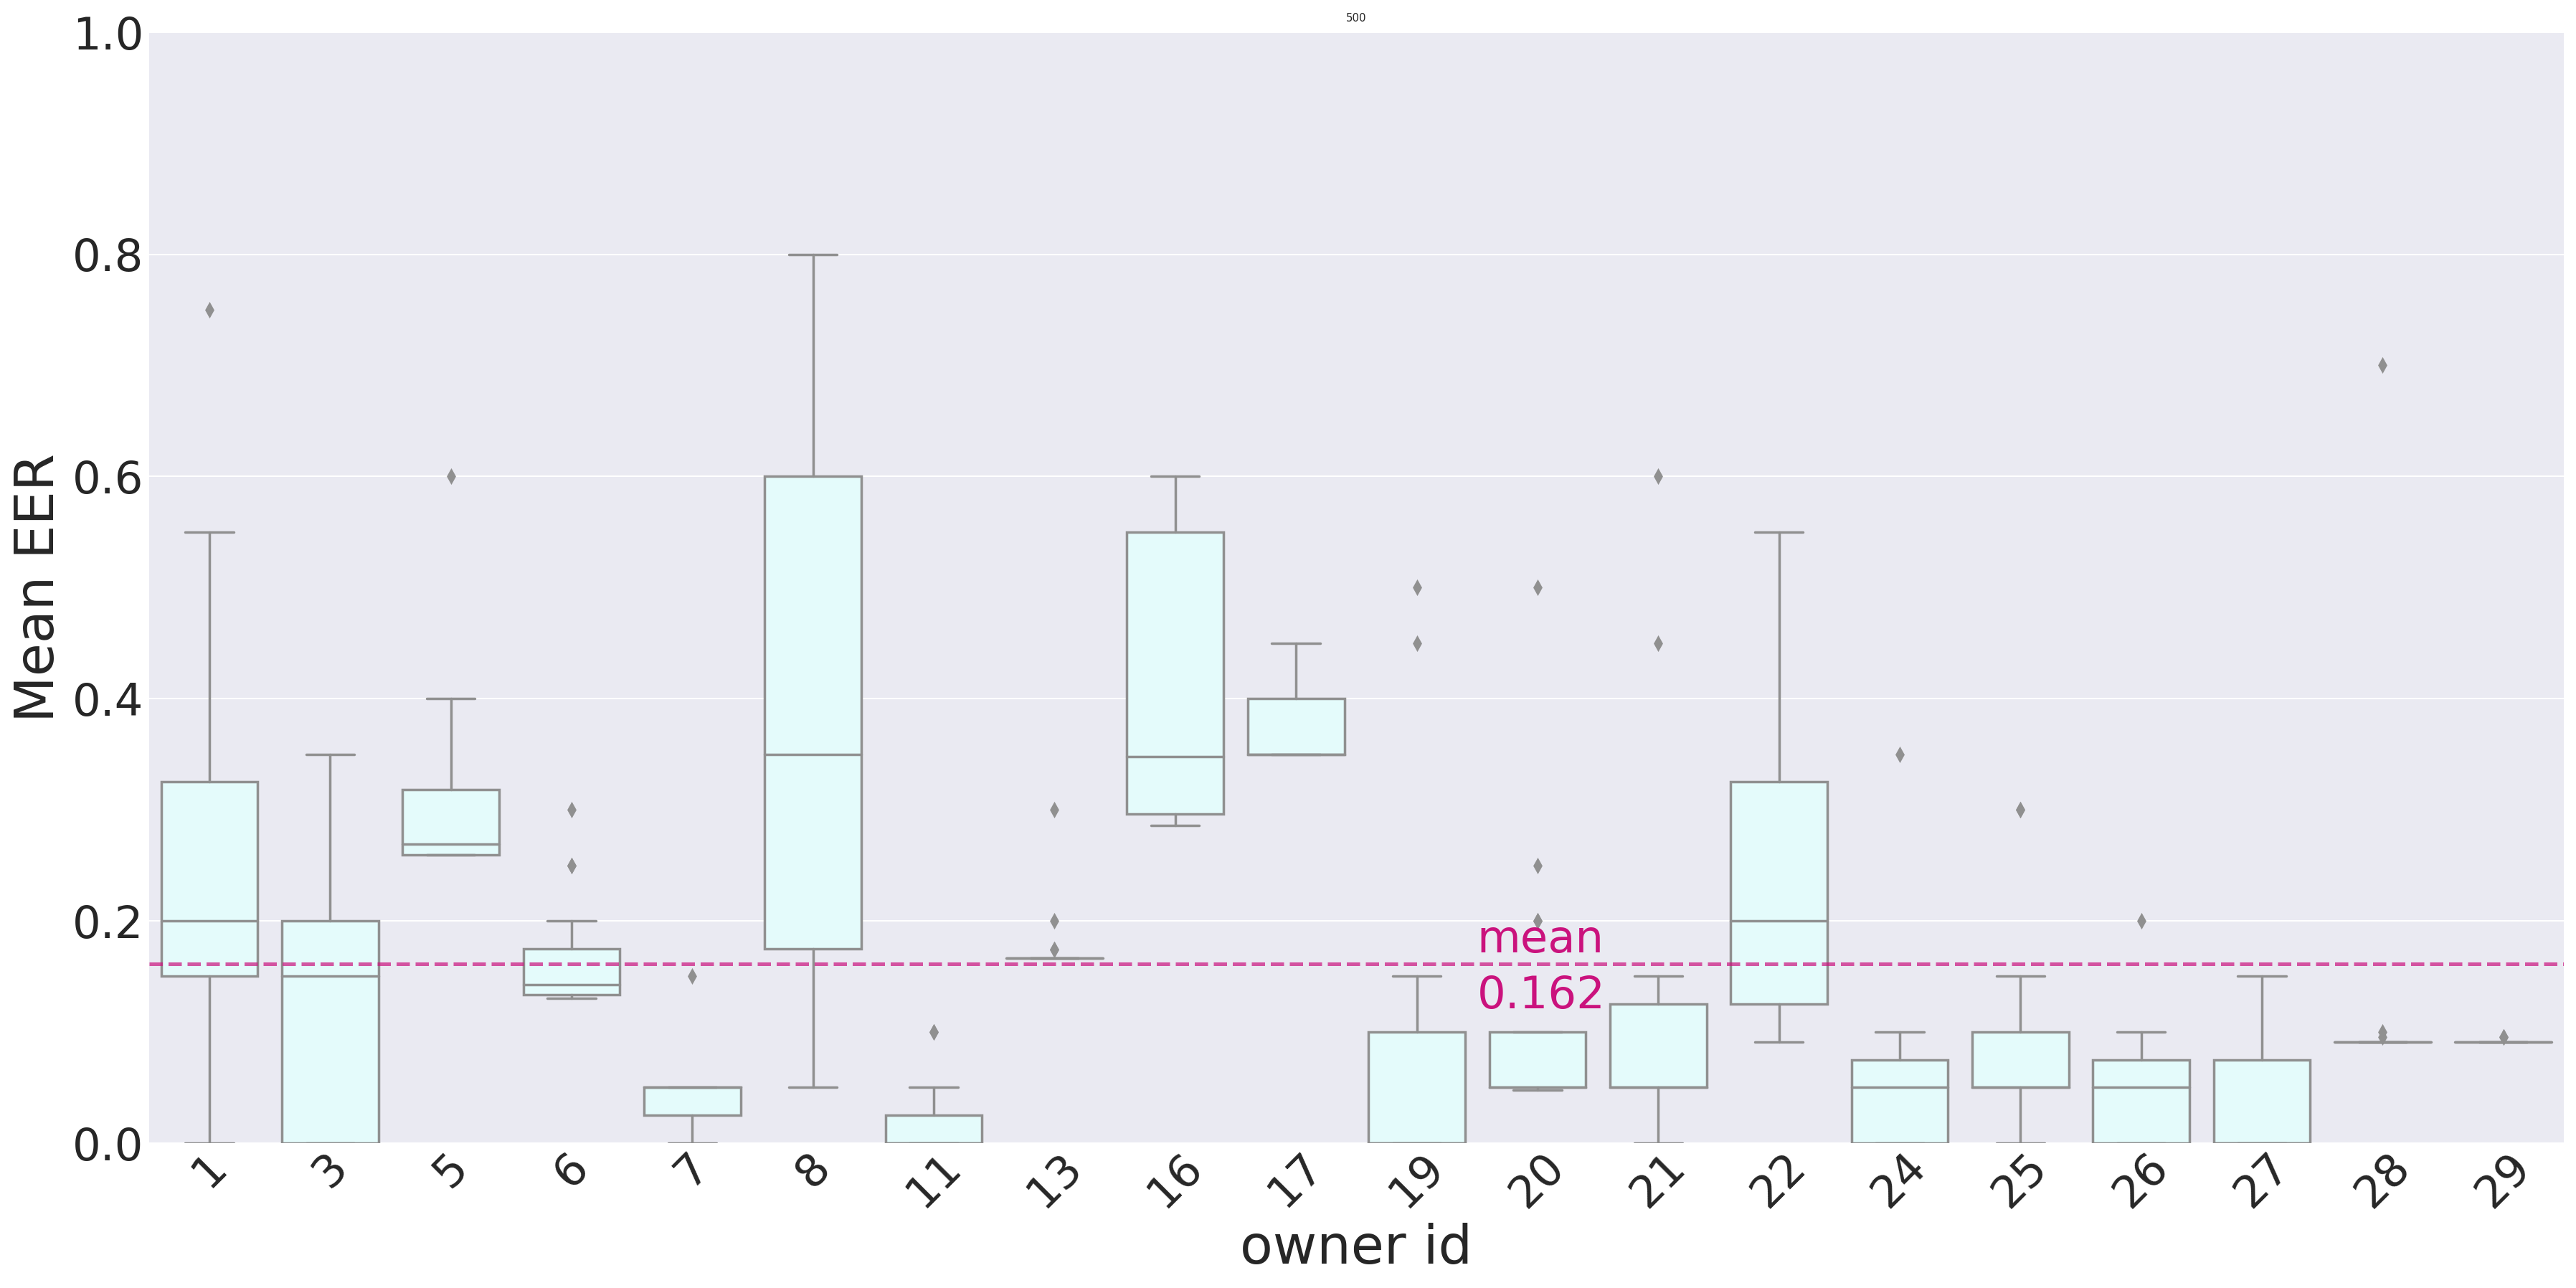

In [76]:
utils_plot_acc_eer_dist_thesis(EER_distro_df, "EER", 500, save_file_name=None, boxplot_color="lightcyan")


Overall mean: 0.2407


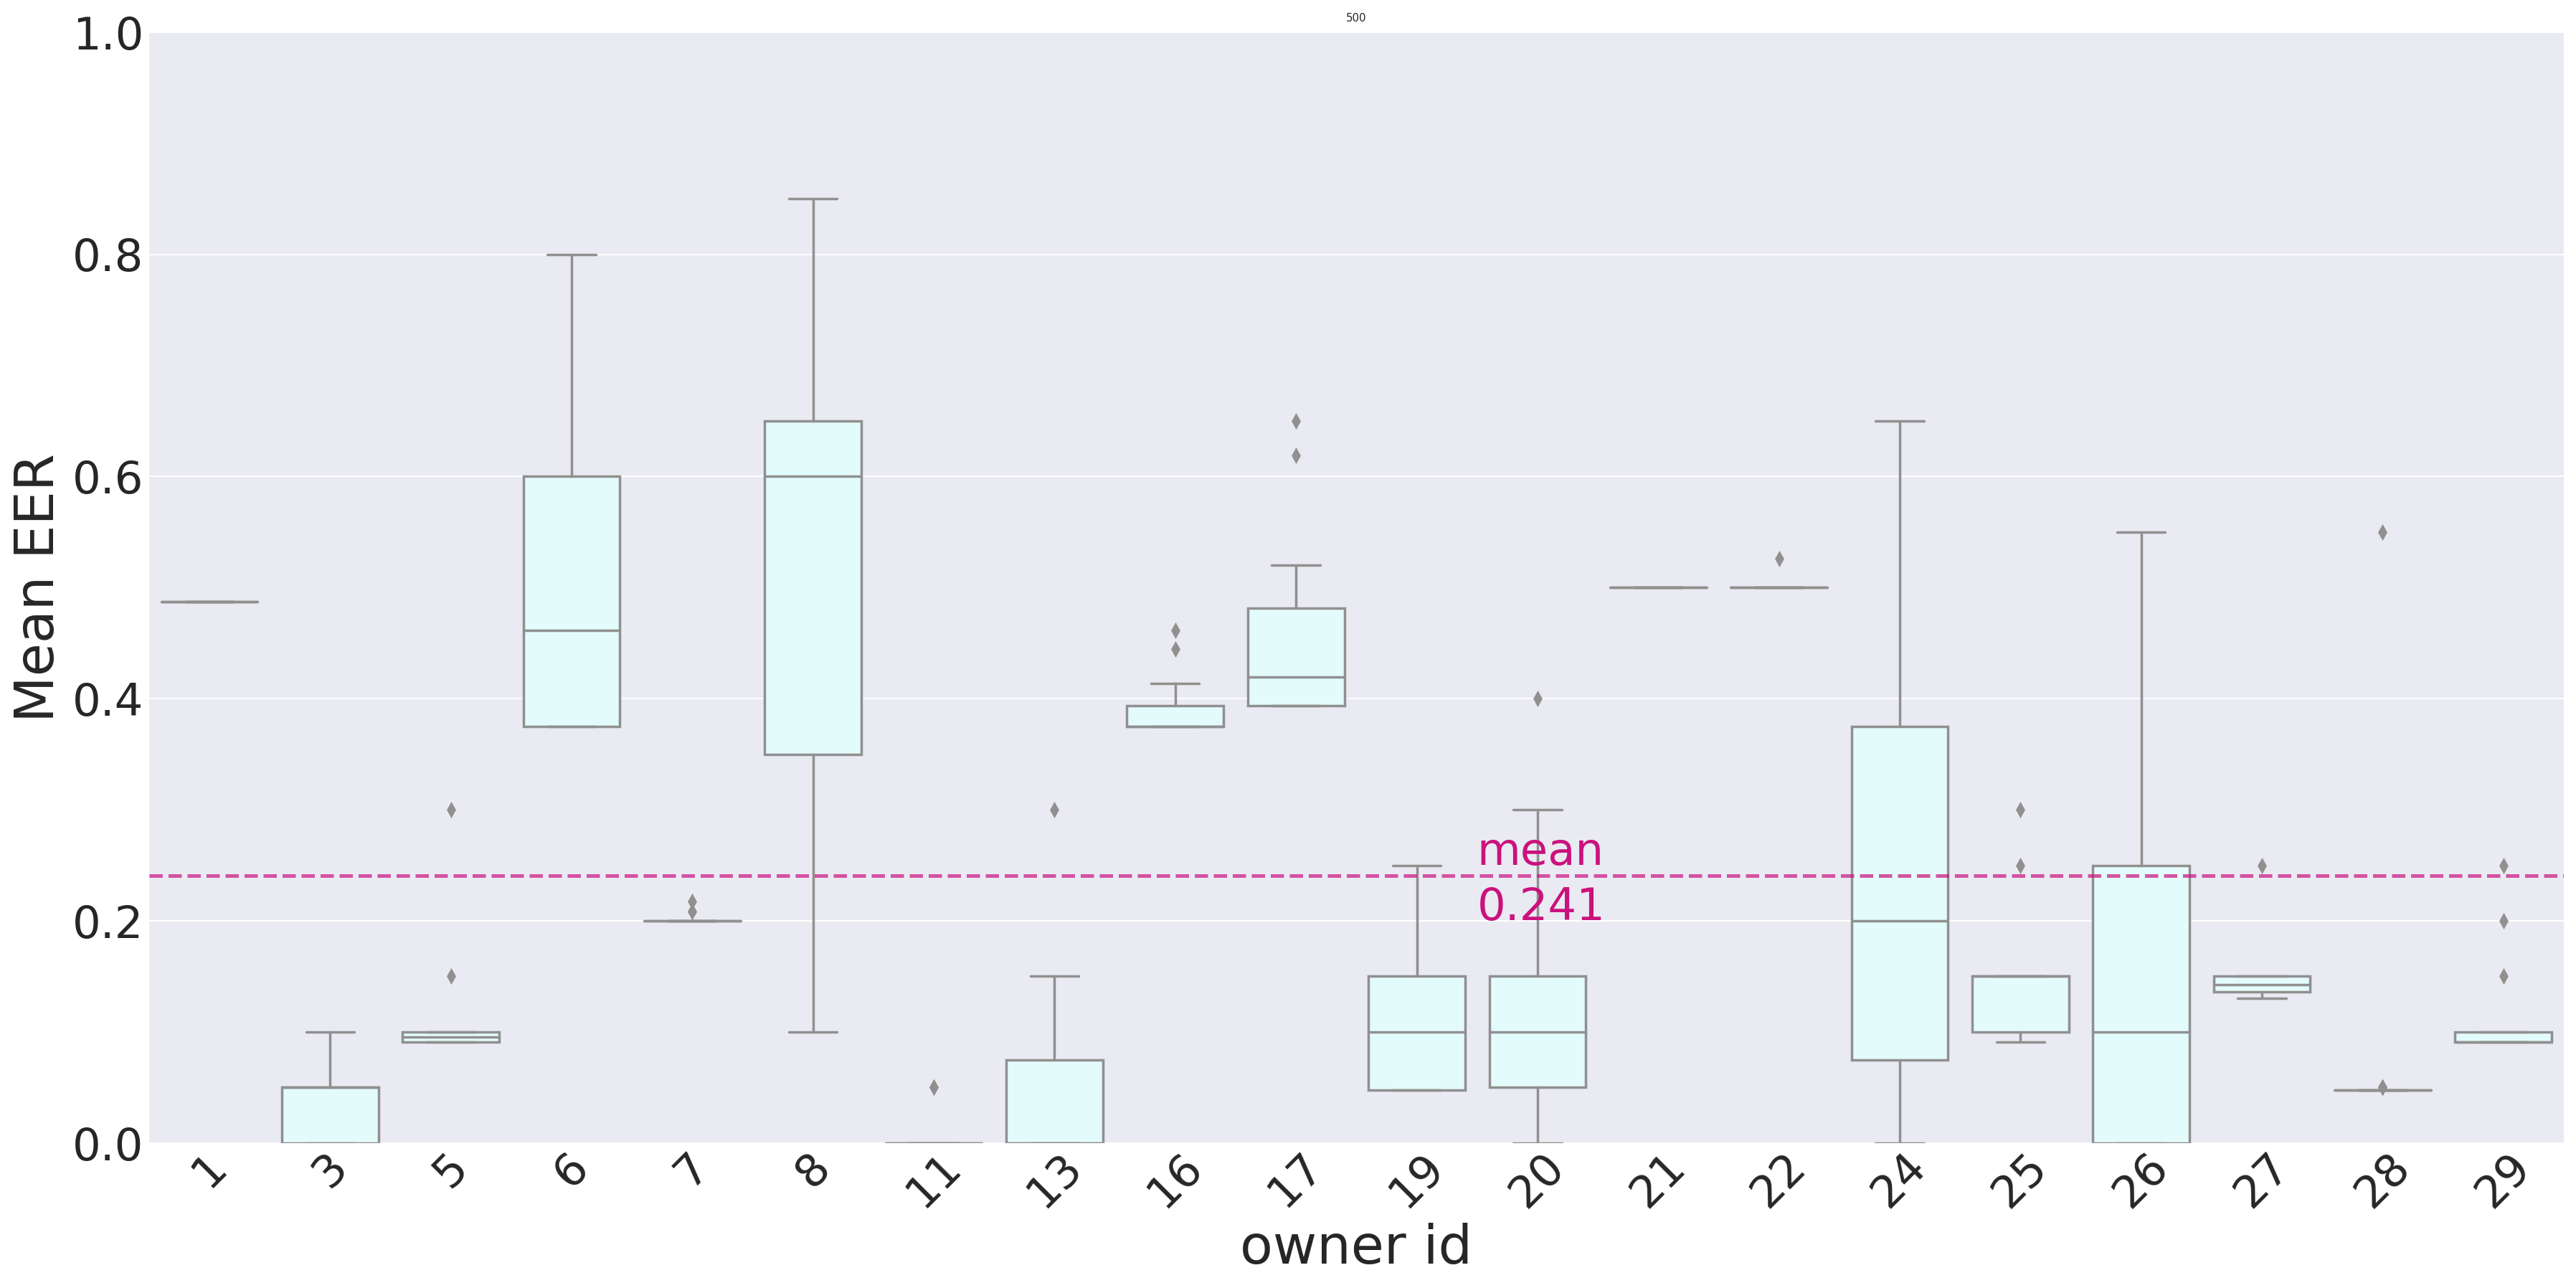

In [64]:
# utils_plot_acc_eer_dist_thesis(EER_distro_df[1]["window_size: 2000, step_width: 1000"], "EER", 500, save_file_name=None, boxplot_color="lightcyan")
utils_plot_acc_eer_dist_thesis(EER_distro_df, "EER", 500, save_file_name=None, boxplot_color="lightcyan")


In [103]:
P.scaler


'RobustScaler'

  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
getRawDataChunks - user_key: 7, exp_num: 1, scaler: None
getRawDataChunks - user_key: 24, exp_num: 1, scaler: None
getRawDataChunks - user_key: 8, exp_num: 1, scaler: None
getRawDataChunks - user_key: 11, exp_num: 1, scaler: None
getRawDataChunks - user_key: 13, exp_num: 1, scaler: None
getRawDataChunks - user_key: 19, exp_num: 1, scaler: None
getRawDataChunks - user_key: 28, exp_num: 1, scaler: None
getRawDataChunks - user_key: 21, exp_num: 1, scaler: None
getRawDataChunks - user_key: 26, exp_num: 1, scaler: None
getRawDataChunks - user_key: 3, exp_num: 1, scaler: None
getRawDataChunks - user_key: 20, exp_num: 1, scaler: None
getRawDataChunks - user_key: 22, exp_num: 1, scaler: None
getRawDataChunks - user_key: 6, exp_num: 1, scaler: None
getRawDataChunks - user_key: 25, exp_num: 1, scaler: None
getRawDataChunks - user_key: 16, exp_num: 1, scaler: None
getRawDataChunks - user_key: 1, exp_num: 1, scaler: No

  0%|          | 0/1 [00:01<?, ?it/s]

getRawDataChunks - user_key: 28, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 21, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 26, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 3, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 20, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 22, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 6, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 25, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 16, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 1, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 17, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 27, exp_num: 2, scaler: RobustScaler()
getRawDataChunks - user_key: 5, exp_num: 2, scaler: RobustScaler()
Done getting raw wondows for window_size: 2000
getRawDataChunks - user_key: 47, exp_num: 1, scaler: None
getRawDataChunk

NameError: name 'extract_features' is not defined

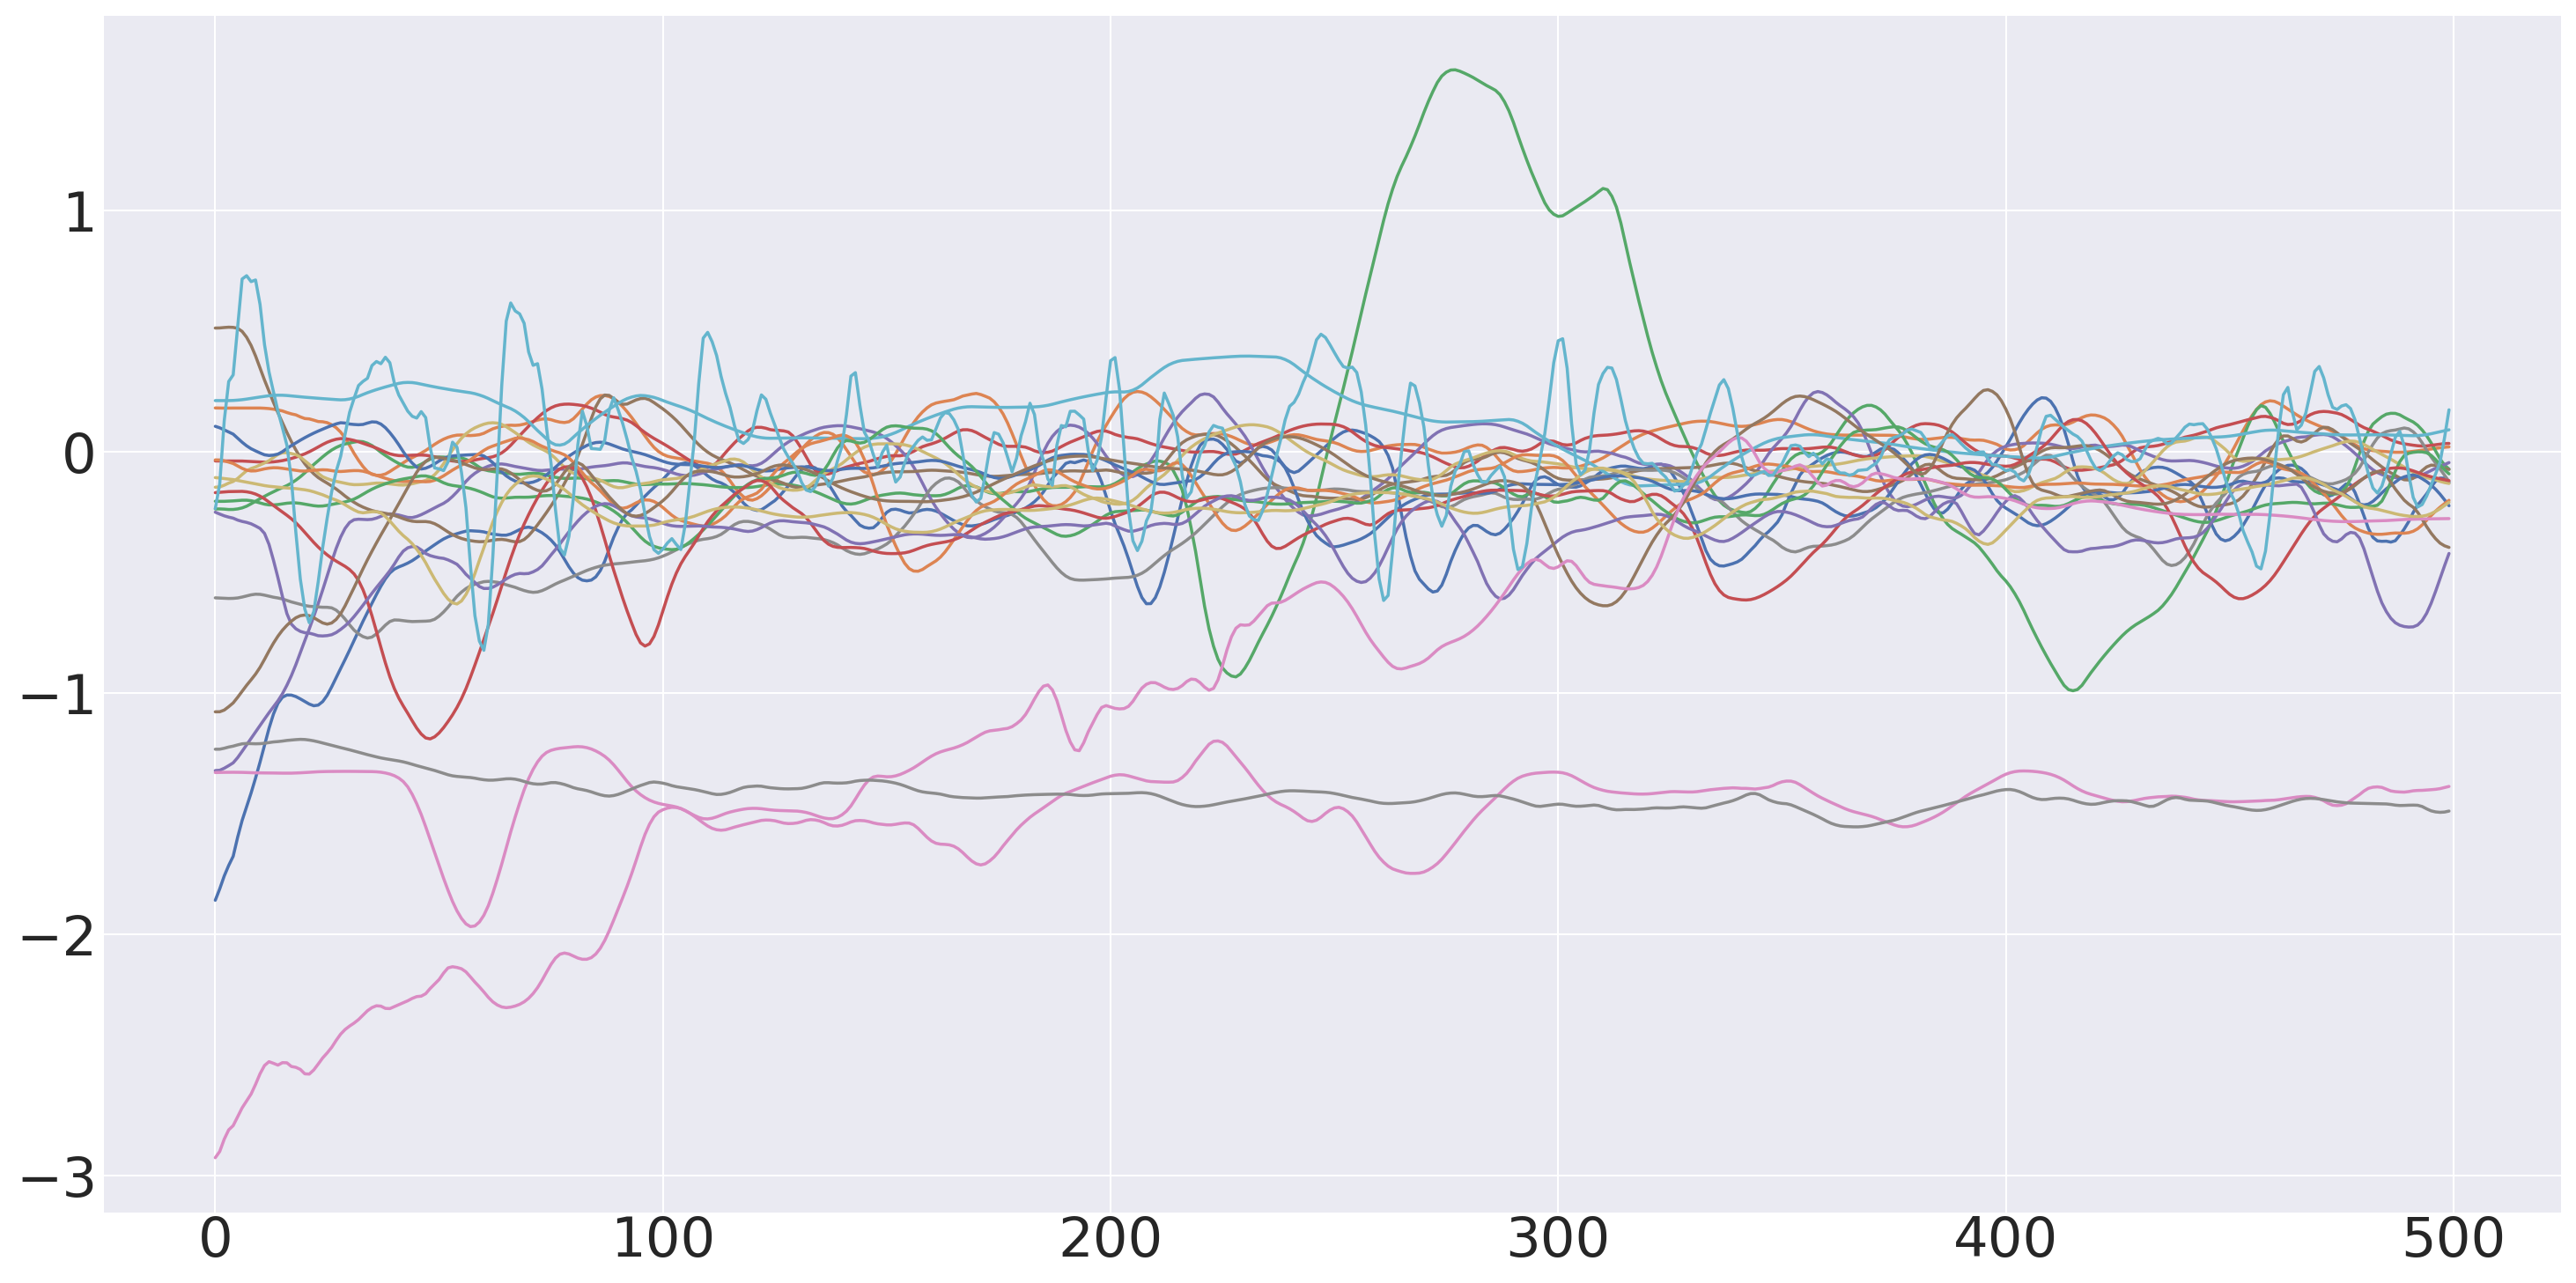

In [100]:
# len(EER_distro_df[EER_distro_df.owner==29])
n_neighbors_params = np.arange(1,20) 
n_neighbors_params=[1]
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 49,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.EMA_per_win_span=None
P.SMA_per_win_winsize=5
P.Butter_per_win_argdict=None
EER_distro_df=calculate_EER_different_window_sizes_optimize_num_neighbors(dfList_dict, window_size_lst=[2000], 
                                                            train_set=train_set, exp_config=P, overlap=.5, n_neighbors_params=n_neighbors_params)

# best_param_df=pd.DataFrame([[2000, 19]], columns=["window_size", "best_n_neighbors"])
# EER_distro_df=calculate_EER_different_window_sizes_test(dfList_dict, window_size_lst=[2000], test_set=test_set, exp_config=P, overlap=.5, best_param_df=best_param_df)

In [345]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 49,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None

# 1. Butterworth frequency Cut-off

## 1.1 Naive Approach
### Optimizing and Testing

In [231]:
print(train_set)
n_neighbors_params = np.arange(1,20) 
window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
# overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
# for overlap in overlap_Mean_EER_df_dict:

overlap=0.5
Butterworth_cut_off_freq_Mean_EER_df_dict={}
for cut_off_freq in tqdm(list(range(49, 50))):
    P.cut_off_freq=cut_off_freq
    P.smoothing = "FFT"
    print(f"cut_off_freq: {P.cut_off_freq}")
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2[0]['x_a'][500:1000].plot()
    exp1_df_dict = ffted_dfList_exp1
    exp2_df_dict = ffted_dfList_exp2
    
    Butterworth_cut_off_freq_Mean_EER_df_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_optimize_num_neighbors(dfList_dict, window_size_lst, 
                                                                                                    train_set=train_set, exp_config=P, overlap=overlap, n_neighbors_params=n_neighbors_params)
    with open("Butterworth_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(Butterworth_cut_off_freq_Mean_EER_df_dict[P.cut_off_freq].to_string())

cut_off_freq_mean_dict={}
for cut_off_freq in Butterworth_cut_off_freq_Mean_EER_df_dict:
    cut_off_freq_mean_dict[cut_off_freq] = Butterworth_cut_off_freq_Mean_EER_df_dict[cut_off_freq]["Mean_EER"].mean()
    
l = list(cut_off_freq_mean_dict.items())
l.sort(key=lambda i: i[1])
l
with open("Butterworth_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for item in l:
        f.write(f"{item}\n")

[7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]


  0%|          | 0/1 [00:00<?, ?it/s]

cut_off_freq: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
Done getting raw wondows for window_size: 2000
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
scaling exp1 unknown windows for when user: 7, is owner
scaling exp1 unknown windows for when user: 24, is owner
scaling exp1 unknown windows for when user: 8, is owner
scaling exp1 unknown windows for when user: 11, is owner
scaling exp1 unknown windows for when user: 13, is owner
scaling exp1 unknown windows for when user: 19, is owner
scaling exp1 unkno


100%|██████████| 1/1 [01:42<00:00, 102.84s/it]


In [ ]:
print(test_set)
overlap=0.5
window_size_lst = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
Butterworth_cut_off_freq_Mean_EER_df_test_dict={}
for cut_off_freq in Butterworth_cut_off_freq_Mean_EER_df_dict:
    P.cut_off_freq=cut_off_freq
    P.smoothing = "FFT"
    print(f"cut_off_freq: {P.cut_off_freq}")
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2[0]['x_a'][500:1000].plot()
    exp1_df_dict = ffted_dfList_exp1
    exp2_df_dict = ffted_dfList_exp2
    Butterworth_cut_off_freq_Mean_EER_df_test_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                         test_set=test_set, overlap=overlap, best_param_df=Butterworth_cut_off_freq_Mean_EER_df_dict[P.cut_off_freq])
    
    with open("Butterworth_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(Butterworth_cut_off_freq_Mean_EER_df_test_dict[P.cut_off_freq].to_string())

        
cut_off_freq_mean_test_dict={}
for cut_off_freq in Butterworth_cut_off_freq_Mean_EER_df_test_dict:
    cut_off_freq_mean_test_dict[cut_off_freq] = Butterworth_cut_off_freq_Mean_EER_df_test_dict[cut_off_freq]["Mean_EER"].mean()
    
l = list(cut_off_freq_mean_test_dict.items())
l.sort(key=lambda i: i[1])
l
with open("Butterworth_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for item in l:
        f.write(f"{item}\n")
        
        

In [104]:
# Butter_cut_off_freq_lst = list(range(50))
# EMA_span_lst = list(range(50))

# Butter_random_search_lst = np.random.choice(Butter_cut_off_freq_lst, 10, replace=False)
# EMA_random_search_lst = np.random.choice(EMA_span_lst, 10, replace=False)

# print(Butter_random_search_lst)
# print(EMA_random_search_lst)

indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
print(index_pairs.shape)
cut_off_span_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]
cut_off_span_pairs.shape

(2401, 2)


(240, 2)

## 1.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

# 2. Butterworth frequency Cut-off + EMA span
## 2.1 Naive Approach
### Optimizing and Testing

In [98]:
# Butter + EMA

print(train_set)
n_neighbors_params = np.arange(1,20) 
window_size_lst = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
# overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
# for overlap in overlap_Mean_EER_df_dict:

indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
choice_num=240
print(f"total cut_off_span_pairs: {index_pairs.shape}, choice_num: {choice_num}")
cut_off_span_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]

overlap=0.5
Butterworth_EMA_cut_off_freq_Mean_EER_df_dict={}
Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict={}
for cut_off_freq, span in tqdm(cut_off_span_pairs):
    
    P.cut_off_freq=cut_off_freq
    P.span=span
    P.smoothing = "Butter+EMA"
    print(f"cut_off_freq: {P.cut_off_freq}")
    print(f"span: {P.span}")
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2[0]['x_a'][500:1000].plot()

    EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
    # EMAed_dfList_exp2[i]['x_a'][500:1000].plot()
    exp1_df_dict = EMAed_dfList_exp1
    exp2_df_dict = EMAed_dfList_exp2

    Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)] = calculate_EER_different_window_sizes_optimize_num_neighbors(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                                                    train_set=train_set, overlap=overlap, n_neighbors_params=n_neighbors_params)
    with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"cut_off_freq: {P.cut_off_freq}, span: {P.span}\n")
        f.write(Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)].to_string())


    Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[(P.cut_off_freq, P.span)] = calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                     test_set=test_set, overlap=overlap, best_param_df=Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)])

    with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"cut_off_freq: {P.cut_off_freq}, span: {P.span}\n")
        f.write(Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[(P.cut_off_freq, P.span)].to_string())


# cut_off_freq_mean_dict={}
# for cut_off_freq in Butterworth_EMA_cut_off_freq_Mean_EER_df_dict:
#     cut_off_freq_mean_dict[cut_off_freq] = Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[cut_off_freq]["Mean_EER"].mean()
    
# l = list(cut_off_freq_mean_dict.items())
# l.sort(key=lambda i: i[1])
# l
# with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
#     f.write("\n" + "-"*22 + "\n")
#     f.write(f"\nSorting based on Mean EER among windows\n")
#     for item in l:
#         f.write(f"{item}\n")
        
        
# cut_off_freq_mean_test_dict={}
# for cut_off_freq in Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict:
#     cut_off_freq_mean_test_dict[cut_off_freq] = Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[cut_off_freq]["Mean_EER"].mean()
    
# l = list(cut_off_freq_mean_test_dict.items())
# l.sort(key=lambda i: i[1])
# l
# with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
#     f.write("\n" + "-"*22 + "\n")
#     f.write(f"\nSorting based on Mean EER among windows\n")
#     for item in l:
#         f.write(f"{item}\n")


        
        


# P.span=23
# P.smoothing = "FFT+EMA"
# # raw_dfList_exp1 = dfList_exp1
# # raw_dfList_exp2 = dfList_exp2
# P.cut_off_freq=17
# ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2[i]['x_a'][500:1000].plot()
# EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
# EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
# EMAed_dfList_exp2[i]['x_a'][500:1000].plot()
# dfList_exp1 = EMAed_dfList_exp1
# dfList_exp2 = EMAed_dfList_exp2

[7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
total cut_off_span_pairs: (2401, 2), choice_num: 240


  0%|          | 0/240 [00:00<?, ?it/s]

cut_off_freq: 21
span: 30


  0%|          | 0/240 [00:01<?, ?it/s]


TypeError: calculate_EER_different_window_sizes_optimize_num_neighbors() got multiple values for argument 'train_set'

In [ ]:
len(train_set)
# train_set

## 2.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

# 3. Butterworth frequency Cut-off + EMA span
## 3.1 Naive Approach
### Optimizing and Testing

In [ ]:
print(train_set)
n_neighbors_params = np.arange(1,20) 
window_size_lst = [750]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
overlap=0.5
print(f"cut_off_freq: {P.cut_off_freq}, span: {P.span}, overlap: {overlap}\n")
Butterworth_EMA_cut_off_freq_Mean_EER_df_dict={}
Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict={}
EER_distro_df_test_dict_dict={}
for cut_off_freq in tqdm([P.cut_off_freq]):
    
    for span in tqdm([P.span]):
        
        P.smoothing = "Butter+EMA"
        print(f"cut_off_freq: {P.cut_off_freq}")
        print(f"span: {P.span}")
        ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
        ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
        # ffted_dfList_exp2[0]['x_a'][500:1000].plot()
        
        EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
        EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
        # EMAed_dfList_exp2[i]['x_a'][500:1000].plot()
        exp1_df_dict = EMAed_dfList_exp1
        exp2_df_dict = EMAed_dfList_exp2

        Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)] = calculate_EER_different_window_sizes_optimize_num_neighbors(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                                                        train_set=train_set, overlap=overlap, n_neighbors_params=n_neighbors_params)
        # with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
        #     f.write("\n" + "-"*22 + "\n")
        #     f.write(f"cut_off_freq: {P.cut_off_freq}, span: {P.span}\n")
        #     f.write(Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)].to_string())
            
            
        Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[(P.cut_off_freq, P.span)], EER_distro_df_test_dict_dict[(P.cut_off_freq, P.span)] = \
                                                    calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst,
                                                    test_set=test_set, overlap=overlap, best_param_df=Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)])
    
        # with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
        #     f.write("\n" + "-"*22 + "\n")
        #     f.write(f"cut_off_freq: {P.cut_off_freq}, span: {P.span}\n")
        #     f.write(Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[(P.cut_off_freq, P.span)].to_string())
# plot_EER_distro(EER_distro_df, discription, save_file_name=None)

## 2.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [ ]:
EER_distro_df_test_dict_dict[(42, 49)]['window_size: 750, step_width: 375, scaler_clip: True']

In [ ]:
Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[(P.cut_off_freq, P.span)] = calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, \
                                                                         test_set=test_set, overlap=overlap, best_param_df=Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[(P.cut_off_freq, P.span)])

In [ ]:
print(Butterworth_EMA_cut_off_freq_Mean_EER_df_dict)
print(Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict)
test_df_results

In [ ]:
test_df_results = EER_distro_df_test_dict_dict[(42, 49)]['window_size: 750, step_width: 375, scaler_clip: True'] 
test_df_plot = test_df_results.rename(
    columns={"owner": "Owner", "EER": "Test EER"}
).astype({"Owner": str})
test_df_plot

In [ ]:
%run ./utility-functions.ipynb
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-kNN-750-Test_EER.svg")


In [ ]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())

In [ ]:

cut_off_freq_EMA_mean_dict={}
for cut_off_freq_span in Butterworth_EMA_cut_off_freq_Mean_EER_df_dict:
    cut_off_freq_EMA_mean_dict[cut_off_freq_span] = Butterworth_EMA_cut_off_freq_Mean_EER_df_dict[cut_off_freq_span]["Mean_EER"].mean()
    
l = list(cut_off_freq_EMA_mean_dict.items())
l.sort(key=lambda i: i[1])
l
with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for item in l:
        f.write(f"{item}\n")
        
        
cut_off_freq_EMA_mean_test_dict={}
for cut_off_freq_span in Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict:
    cut_off_freq_EMA_mean_test_dict[cut_off_freq_span] = Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict[cut_off_freq_span]["Mean_EER"].mean()
    
l = list(cut_off_freq_EMA_mean_test_dict.items())
l.sort(key=lambda i: i[1])
l
with open("Butterworth_EMA_cut_off_freq_Mean_EER_df_test_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for item in l:
        f.write(f"{item}\n")


In [ ]:
P.cut_off_freq=49
P.smoothing = "FFT"
print(f"cut_off_freq: {P.cut_off_freq}")
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
exp1_df_dict = ffted_dfList_exp1
exp2_df_dict = ffted_dfList_exp2

In [ ]:
P.cut_off_freq=20
P.smoothing = "FFT"
print(f"cut_off_freq: {P.cut_off_freq}")
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=2, filter_order=30)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
exp1_df_dict = ffted_dfList_exp1
exp2_df_dict = ffted_dfList_exp2

In [ ]:
EMA_span_Mean_EER_df_dict = {}
for span in tqdm(list(range(1, 51))):
    EMA_span_Mean_EER_df_dict[span]=None
EMA_span_Mean_EER_df_dict

# Optimizing EMA span

In [ ]:
print(train_set)
n_neighbors_params = np.arange(1,20) 
window_size_lst = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
# overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
# for overlap in overlap_Mean_EER_df_dict:


overlap=0.5
for span in tqdm(list(range(6, 51))):#tqdm(EMA_span_Mean_EER_df_dict):
    P.span=span
    P.smoothing = "EMA"
    print(f"span: {P.span}")
    EMAed_dfList_exp1 = get_EMAed_dfList(raw_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    # EMAed_dfList_exp2[0]['x_a'][500:1000].plot()
    exp1_df_dict = EMAed_dfList_exp1
    exp2_df_dict = EMAed_dfList_exp2
    EMA_span_Mean_EER_df_dict[P.span] = calculate_EER_different_window_sizes_optimize_num_neighbors(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                                                    train_set=train_set, overlap=overlap, n_neighbors_params=n_neighbors_params)
    with open("EMA_span_Mean_EER_df_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\nSpan: {P.span}\n")
        f.write(EMA_span_Mean_EER_df_dict[P.span].to_string())
    

In [ ]:
span_mean_dict={}
for span in EMA_span_Mean_EER_df_dict:
    span_mean_dict[span] = EMA_span_Mean_EER_df_dict[span]["Mean_EER"].mean()
    
l = list(span_mean_dict.items())
l.sort(key=lambda i: i[1])
l
with open("EMA_span_Mean_EER_df_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting\n")
    for item in l:
        f.write(f"{item}\n")

# Testing the optimal EMA span

In [ ]:
print(test_set)
overlap=0.5
window_size_lst = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
EMA_span_Mean_EER_df_test_dict={}
for span in EMA_span_Mean_EER_df_dict:
    P.span=span
    P.smoothing = "EMA"
    print(f"span: {P.span}")
    EMAed_dfList_exp1 = get_EMAed_dfList(raw_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    # EMAed_dfList_exp2[0]['x_a'][500:1000].plot()
    exp1_df_dict = EMAed_dfList_exp1
    exp2_df_dict = EMAed_dfList_exp2
    EMA_span_Mean_EER_df_test_dict[P.span] = calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                         test_set=test_set, overlap=overlap, best_param_df=EMA_span_Mean_EER_df_dict[P.span])
    with open("EMA_span_Mean_EER_df_test_dict.txt", "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\nSpan: {P.span}\n")
        f.write(EMA_span_Mean_EER_df_test_dict[P.span].to_string())

In [ ]:
span_mean_test_dict={}
for span in EMA_span_Mean_EER_df_test_dict:
    span_mean_test_dict[span] = EMA_span_Mean_EER_df_test_dict[span]["Mean_EER"].mean()
l = list(span_mean_test_dict.items())
l.sort(key=lambda i: i[1])
l
with open("EMA_span_Mean_EER_df_test_dict.txt", "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for item in l:
        f.write(f"{item}\n")

In [ ]:
EMA_span_Mean_EER_df_test_dict

In [ ]:
f = open("EMA_span_Mean_EER_df_dict.txt", "w")
for span in range(1, 6):
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSpan: {span}\n")
    f.write(EMA_span_Mean_EER_df_dict[span].to_string())
f.close()

In [ ]:
overlap_Mean_EER_df_dict

In [ ]:
overlap_Mean_EER_df_dict

# Optimizing SMA winsize

# Testing the Optimal Butterworth frequency Cut-off + SMA winsize

# Optimizing Butterworth frequency Cut-off + SMA winsize

# Testing the Optimal Butterworth frequency Cut-off + SMA winsize

# The effect of Varying Overlap

In [ ]:
print(train_set)
n_neighbors_params = np.arange(1,20) 
overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
for overlap in overlap_Mean_EER_df_dict:
    overlap_Mean_EER_df_dict[overlap] = calculate_EER_different_window_sizes_optimize_num_neighbors(overlap=overlap, n_neighbors_params=n_neighbors_params, train_set=train_set)

In [ ]:
# np.mean([3.3125922  ,3.53365675, 3.70292311])

In [ ]:
# X_exp1_train_dic.keys()

In [ ]:
overlap_Mean_EER_df_dict[.5]

In [ ]:
int(overlap_Mean_EER_df_dict[.5][overlap_Mean_EER_df_dict[.5].window_size==2000].best_n_neighbors)

In [ ]:
overlap = .5
overlap_Mean_EER_df_dict[overlap]

In [ ]:
print(test_set)
overlap_Mean_EER_df_test = calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, 
                                                                     test_set=test_set, overlap=overlap, best_param_df=overlap_Mean_EER_df_dict[overlap])
overlap_Mean_EER_df_test

In [ ]:
overlap_Mean_EER_df_test

In [ ]:
end_here

In [ ]:
f = open("overlap_Mean_EER_df_dict_95.txt", "a")
f.write(overlap_Mean_EER_df_dict[0.99].to_string())
f.close()